In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool, contextual_search
tools = [tavily_search, think_tool, contextual_search]

In [3]:
# Test contextual_search tool
print("Testing contextual_search tool...")
print("=" * 80)

# Test with a sample query (adjust based on your knowledge base)
test_query = "what is microsofts revenue?"
print(f"\nQuery: {test_query}\n")

try:
    result = contextual_search.invoke({"query": test_query, "max_results": 5})
    print(result)
    print("\n" + "=" * 80)
    print("✅ contextual_search tool is working!")
except Exception as e:
    print(f"\n❌ Error testing contextual_search: {e}")
    print("\nMake sure you have:")
    print("1. CONTEXTUAL_AI_API_KEY set in your .env file")
    print("2. CONTEXTUAL_AI_AGENT_ID set in your .env file")
    print("3. The 'contextual' package installed: pip install contextual")


Testing contextual_search tool...

Query: what is microsofts revenue?

🔍 Found 5 result(s) for 'what is microsofts revenue?' in ContextualAI knowledge base:

## msft_10q_fy2024q1
**Attribution:** Context ID: 90257057-e8c4-befe-aeaf-dd477d3c9ba3 | Doc ID: a178298f-e14b-49bc-94af-42cc2a188699 | Page: 32 | Score: 0.9829

Filename: Microsoft 10-Q FY2024 Q1
Section: PART I
Sub-Section: ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL  CONDITION AND RESUL TS OF OPERATIONS
Sub-Sub-Section: OVERVIEW
Microsoft is a technology company whose mission is to empower every person and every organization on  the planet to achieve more. We strive to create local opportunity, growth, and impact in every country  around the world. We are creating the platforms and tools, powered by artificial intelligence (“AI”), that  deliver better, faster, and more effective solutions to support small and large business competitiveness,  improve educational and health outcomes, grow public-sector efficiency, a

In [4]:
# Optional: Inspect raw ContextualAI response structure
# This helps you understand what data is available
import os
from contextual import ContextualAI

api_key = os.getenv("CONTEXTUAL_AI_API_KEY")
agent_id = os.getenv("CONTEXTUAL_AI_AGENT_ID")

if api_key and agent_id:
    client = ContextualAI(api_key=api_key)
    
    # Get raw response WITH content text included
    query_result = client.agents.query.create(
        agent_id=agent_id,
        messages=[{"content": "what is microsofts revenue?", "role": "user"}],
        retrievals_only=True,
        include_retrieval_content_text=True  # This is the key parameter!
    )
    
    print("Raw QueryResponse structure:")
    print(f"Conversation ID: {query_result.conversation_id}")
    print(f"Number of retrieval contents: {len(query_result.retrieval_contents)}")
    print("\n" + "=" * 80)
    
    # Show first result details
    if query_result.retrieval_contents:
        first_result = query_result.retrieval_contents[0]
        print("\nFirst result structure:")
        print(f"  - doc_name: {getattr(first_result, 'doc_name', 'N/A')}")
        print(f"  - content_id: {getattr(first_result, 'content_id', 'N/A')}")
        print(f"  - doc_id: {getattr(first_result, 'doc_id', 'N/A')}")
        print(f"  - page: {getattr(first_result, 'page', 'N/A')}")
        print(f"  - format: {getattr(first_result, 'format', 'N/A')}")
        print(f"  - score: {getattr(first_result, 'score', 'N/A')}")
        print(f"  - content_text available: {getattr(first_result, 'content_text', None) is not None}")
        if hasattr(first_result, 'content_text') and first_result.content_text:
            print(f"\n  - content_text preview (first 300 chars):")
            print(f"    {first_result.content_text[:300]}...")
        else:
            print(f"\n  ⚠️  content_text is None or empty")
            print(f"  Make sure you're using include_retrieval_content_text=True in the query!")
else:
    print("⚠️  ContextualAI credentials not found. Skipping raw response inspection.")


Raw QueryResponse structure:
Conversation ID: 5adbc44f-00a9-4cae-b29d-137757f416af
Number of retrieval contents: 15


First result structure:
  - doc_name: msft_10q_fy2024q1
  - content_id: 90257057-e8c4-befe-aeaf-dd477d3c9ba3
  - doc_id: a178298f-e14b-49bc-94af-42cc2a188699
  - page: 32
  - format: pdf
  - score: 0.9829475932644243
  - content_text available: True

  - content_text preview (first 300 chars):
    Filename: Microsoft 10-Q FY2024 Q1
Section: PART I
Sub-Section: ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL  CONDITION AND RESUL TS OF OPERATIONS
Sub-Sub-Section: OVERVIEW
Microsoft is a technology company whose mission is to empower every person and every organization on  the planet t...


## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [5]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [6]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  3. **contextual_search**: For conducting RAG-based document search on historical market data, such as 10ks,    │
│  10q, etc.                                                                                                      │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  6. **Favor using contextual_search over tavily_search except for latest news in 2025**                         │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maxim

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [7]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [contextual_search, tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [8]:
# Limits
max_concurrent_research_units = 2
max_researcher_iterations = 2

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [9]:
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model
#from langchain_google_genai import ChatGoogleGenerativeAI

# Model Gemini 3 
#model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

# Model Claude 4.5
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

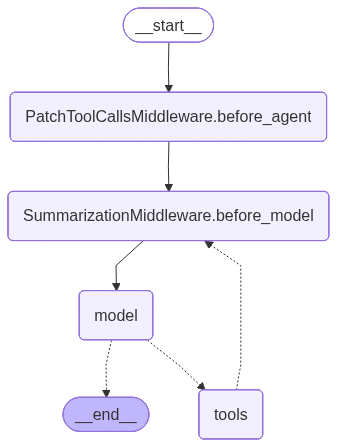

In [10]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Based on NVIDIA's past performance, what is their best strategy for the future?",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Based on NVIDIA's past performance, what is their best strategy for the future?                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll research NVIDIA's past performance and analyze their best strategy for the future. Let me break this down  │
│ into focused research tasks.                                                                                    │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's historical performance, key business segments, and strategic    │
│ moves to a sub-agent",                                                                                          │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's current market position, competitive landscape, and future      │
│ opportunities to a sub-agent",                                                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive final report to /final_report.md",                │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify the report addresses all aspects of the research request",                             │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01D1Sj8qWNhJEjNUc4URgL8k                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status':                │
│ 'in_progress'}, {'content': "Delegate research on NVIDIA's historical performance, key business segments, and   │
│ strategic moves to a sub-agent", 'status': 'pending'}, {'content': "Delegate research on NVIDIA's current       │
│ market position, competitive landscape, and future opportunities to a sub-agent", 'status': 'pending'},         │
│ {'content': 'Synthesize findings and write comprehensive final report to /final_report.md', 'status':           │
│ 'pending'}, {'content': 'Verify the report addresses all aspects of the research request', 'status':            │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "# Research Request\n\nBased on NVIDIA's past performance, what is their best strategy for the     │
│ future?\n\n## Key Questions to Address:\n1. What has driven NVIDIA's past success?\n2. What are their key       │
│ business segments and performance trends?\n3. What strategic moves have been most successful?\n4. What is their │
│ current market position and competitive landscape?\n5. What future opportunities and challenges exist?\n6. What │
│ strategic recommendations emerge from this analysis?\n"                                                         │
│ }                                                                                                               │
│    ID: toolu_01QDYKFuCZ34C7Q8WynN7Xbb                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's historical performance, key business segments, and strategic    │
│ moves to a sub-agent",                                                                                          │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's current market position, competitive landscape, and future      │
│ opportunities to a sub-agent",                                                                                  │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive final report to /final_report.md",                │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify the report addresses all aspects of the research request",                             │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Q47hncEA99LfoGENVwbMkz                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on NVIDIA's historical performance, key business segments, and strategic moves   │
│ to a sub-agent", 'status': 'in_progress'}, {'content': "Delegate research on NVIDIA's current market position,  │
│ competitive landscape, and future opportunities to a sub-agent", 'status': 'in_progress'}, {'content':          │
│ 'Synthesize findings and write comprehensive final report to /final_report.md', 'status': 'pending'},           │
│ {'content': 'Verify the report addresses all aspects of the research request', 'status': 'pending'}]            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research NVIDIA's historical performance and strategic evolution. Focus on:\n\n1.             │
│ **Historical Performance (last 5-10 years)**:\n   - Revenue and profit growth trends\n   - Stock performance    │
│ and market capitalization growth\n   - Key financial metrics and milestones\n\n2. **Key Business Segments**:\n  │
│ - Gaming (GeForce GPUs)\n   - Data Center (AI/ML, cloud computing)\n   - Professional Visualization\n   -       │
│ Automotive\n   - Performance and contribution of each segment over time\n\n3. **Strategic Moves and Pivots**:\n │
│ - Transition from gaming-focused to AI/data center leader\n   - Key acquisitions (Mellanox, ARM attempt,        │
│ etc.)\n   - Technology innovations (CUDA, Tensor cores, etc.)\n   - Partnership strategies\n\n4. **What Drove   │
│ Their Success**:\n   - Technology advantages\n   - Market timing decisions\n   - Platform/ecosystem             │
│ strategies\n\nReturn a comprehensive report with:\n- Clear sections for each topic above\n- Specific data       │
│ points, revenue figures, and growth percentages\n- Timeline of key strategic decisions\n- All sources cited     │
│ with full URLs\n\nThis is for analysis purposes, so provide detailed findings with proper citations."           │
│ }                                                                                                               │
│    ID: toolu_01LExRp6TdN1z6fZdPGQVutE                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research NVIDIA's current market position and future strategic opportunities. Focus on:\n\n1. │
│ **Current Market Position (2023-2024)**:\n   - Market share in key segments (AI chips, gaming GPUs, data        │
│ center)\n   - Competitive advantages and moats\n   - Recent financial performance and guidance\n\n2.            │
│ **Competitive Landscape**:\n   - Main competitors (AMD, Intel, custom AI chips from Google/Amazon/Microsoft)\n  │
│ - Competitive threats and challenges\n   - How NVIDIA maintains its lead\n\n3. **Future Opportunities**:\n   -  │
│ AI and generative AI growth potential\n   - Emerging markets (edge AI, robotics, autonomous vehicles)\n   -     │
│ Software and services expansion\n   - Geographic expansion opportunities\n\n4. **Challenges and Risks**:\n   -  │
│ Supply chain and manufacturing constraints\n   - Geopolitical risks (China restrictions, export controls)\n   - │
│ Competition intensifying\n   - Customer concentration risks\n\n5. **Industry Trends**:\n   - AI infrastructure  │
│ buildout\n   - Sovereign AI initiatives\n   - Custom chip development by hyperscalers\n\nReturn a comprehensive │
│ report with:\n- Clear sections for each topic above\n- Specific market data, forecasts, and competitive         │
│ analysis\n- Forward-looking insights on opportunities and threats\n- All sources cited with full URLs\n\nThis   │
│ is for strategic analysis purposes, so provide detailed f

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Now I'll compile a comprehensive report based on the extensive data I've gathered from NVIDIA's financial       │
│ filings.                                                                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ # NVIDIA Historical Performance and Strategic Evolution: Comprehensive Analysis                                 │
│                                                                                                                 │
│ ## Executive Summary                                                                                            │
│                                                                                                                 │
│ NVIDIA has undergone one of the most remarkable transformations in technology history, evolving from a gaming   │
│ GPU company to the dominant force in AI computing. Between fiscal years 2021 and 2024, the company's revenue    │
│ grew from $16.7B to $60.9B (265% growth), while net income surged from $4.3B to $29.8B (593% growth). This      │
│ transformation was driven by strategic foresight in AI/data center computing, the CUDA ecosystem, and key       │
│ acquisitions that positioned NVIDIA at the center of the generative AI revolution [1].                          │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Historical Financial Performance (FY2021-FY2024)                                                          │
│                                                                                                                 │
│ ### Revenue Growth Trajectory                                                                                   │
│                                                                                                                 │
│ NVIDIA's revenue growth demonstrates a dramatic acceleration, particularly in FY2024:                           │
│                                                                                                                 │
│ | Fiscal Year | Revenue | YoY Growth | Net Income | YoY Growth |                                                │
│ |-------------|---------|------------|------------|------------|                                                │
│ | **FY2021** | $16.68B | - | $4.33B | - |                                                                       │
│ | **FY2022** | $26.91B | +61% | $9.75B | +125% |                                                                │
│ | **FY2023** | $26.97B | ~0% | $4.37B | -55% |                                                                  │
│ | **FY2024** | $60.92B | +126% | $29.76B | +581% |                                                              │
│                                                                                                                 │
│ **Key Observations:**                                                                                           │
│                                                                                                                 │
│ - **FY2022**: Explosive 61% revenue growth driven by strong demand across Gaming (Ampere architecture GPUs) and │
│ Data Center segments, with net income growing 125% [2] 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Now I'll compile a comprehensive report with all my findings:                                                   │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ # NVIDIA Strategic Analysis: Market Position and Future Opportunities                                           │
│                                                                                                                 │
│ ## Executive Summary                                                                                            │
│                                                                                                                 │
│ NVIDIA has established an unprecedented dominant position in the AI chip market, commanding over 90% market     │
│ share in data center GPUs and over 80% in AI processors [1]. The company's fiscal year 2024 performance was     │
│ exceptional, with revenue reaching $60.9 billion (up 126% year-over-year), driven primarily by explosive growth │
│ in its Data Center segment, which generated $47.5 billion in revenue (up 217% YoY) [2]. This dominance is       │
│ underpinned by NVIDIA's CUDA software ecosystem, creating substantial switching costs for customers, though     │
│ competitive threats are intensifying from both traditional semiconductor rivals and hyperscaler custom chip     │
│ initiatives.                                                                                                    │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Current Market Position (2023-2024)                                                                       │
│                                                                                                                 │
│ ### Financial Performance Overview                                                                              │
│                                                                                                                 │
│ NVIDIA's financial performance in FY2024 represents one of the most dramatic growth trajectories in             │
│ semiconductor history:                                                                                          │
│                                                                                                                 │
│ **Fiscal Year 2024 Results:**                                                                                   │
│ - **Total Revenue:** $60.9 billion (up 126% YoY from $27.0 billion in FY2023) [2]                               │
│ - **Gross Margin:** 72.7% (up 15.8 percentage points YoY) [2]                                                   │
│ - **Operating Income:** $33.0 billion (up 681% YoY) [2]                                                         │
│ - **Net Income:** $29.8 billion (up 581% YoY) [2]                                                               │
│ - **Diluted EPS:** $11.93 (up 586% YoY) [2]                                                                     │
│                                                                                                                 │
│ **Q2 FY2024 Quarterly Highlights:**                                                                             │
│ - Revenue of $13.5 billion represented 101% YoY growth 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's historical performance, key business segments, and strategic    │
│ moves to a sub-agent",                                                                                          │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's current market position, competitive landscape, and future      │
│ opportunities to a sub-agent",                                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive final report to /final_report.md",                │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify the report addresses all aspects of the research request",                             │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Sq8V4Z1CPzmiJB15bxXCRM                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on NVIDIA's historical performance, key business segments, and strategic moves   │
│ to a sub-agent", 'status': 'completed'}, {'content': "Delegate research on NVIDIA's current market position,    │
│ competitive landscape, and future opportunities to a sub-agent", 'status': 'completed'}, {'content':            │
│ 'Synthesize findings and write comprehensive final report to /final_report.md', 'status': 'in_progress'},       │
│ {'content': 'Verify the report addresses all aspects of the research request', 'status': 'pending'}]            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll synthesize the findings from both research sub-agents and write a comprehensive final report analyzing │
│ NVIDIA's best strategy for the future based on their past performance.                                          │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# NVIDIA's Best Strategy for the Future: Analysis Based on Past Performance\n\n## Executive       │
│ Summary\n\nNVIDIA's transformation from a $16.7 billion gaming GPU company in fiscal year 2021 to a $60.9       │
│ billion AI computing infrastructure leader in fiscal year 2024 represents one of the most successful strategic  │
│ pivots in technology history [1][2]. This remarkable 265% revenue growth, accompanied by 593% net income        │
│ growth, was driven by strategic foresight in AI acceleration, the CUDA ecosystem, and key acquisitions that     │
│ positioned NVIDIA at the center of the generative AI revolution [1][2]. Based on this historical performance,   │
│ NVIDIA's optimal future strategy should focus on defending and extending its CUDA moat, accelerating            │
│ diversification beyond hyperscaler customers, maintaining technological leadership through rapid innovation     │
│ cycles, and strategically navigating geopolitical challenges while expanding into high-growth verticals         │
│ including Sovereign AI, automotive, and inference workloads.\n\n## Historical Performance: Key Success          │
│ Drivers\n\n### Financial Transformation\n\nNVIDIA's financial trajectory demonstrates exceptional execution     │
│ during a period of market transformation. Between fiscal years 2021 and 2024, the company achieved revenue      │
│ growth from $16.68 billion to $60.92 billion, while net income surged from $4.33 billion to $29.76 billion [1]. │
│ The most dramatic acceleration occurred in fiscal year 2024, with 126% year-over-year revenue growth driven by  │
│ the generative AI boom [2].\n\nThe company's profitability metrics improved substantially, with gross margins   │
│ expanding from 56.9% in fiscal year 2023 to approximately 72.7% in fiscal year 2024 [2]. Operating income       │
│ reached $32.97 billion in fiscal year 2024, representing 681% growth year-over-year [2]. This performance was   │
│ particularly impressive given the challenges faced in fiscal year 2023, including $2.17 billion in inventory    │
│ provisions, macroeconomic headwinds, and a $1.35 billion ARM acquisition termination cost [3].\n\n### Strategic │
│ Business Segment Evolution\n\nNVIDIA's most significant strategic achievement was the successful pivot from     │
│ gaming-focused to data center-dominated revenue. The Data Center segment grew from $11.05 billion (41% of total │
│ revenue) in fiscal year 2022 to $47.41 billion (78% of total revenue) in fiscal year 2024, representing 215%    │
│ growth [4][5]. This transformation was driven by demand for AI training and inference, with the Hopper          │
│ architecture H100 GPU becoming the foundation for large language models and generative AI applications          │
│ [6].\n\nThe Gaming segment, while experiencing volatility due to inventory corrections and macroeconomic        │
│ factors, demonstrated resilience with fiscal year 2024 revenue of $10.4 billion, recovering 15% year-over-year  │
│ with the RTX 40 Series Ada Lovelace architecture [5]. Professional Visualization stabilized at $1.6 billion,    │
│ while Automotive grew 21% to $1.1 billion, driven by the

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's historical performance, key business segments, and strategic    │
│ moves to a sub-agent",                                                                                          │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's current market position, competitive landscape, and future      │
│ opportunities to a sub-agent",                                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive final report to /final_report.md",                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify the report addresses all aspects of the research request",                             │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01RBEuoWDHdtwrz3xpFz7kfA                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on NVIDIA's historical performance, key business segments, and strategic moves   │
│ to a sub-agent", 'status': 'completed'}, {'content': "Delegate research on NVIDIA's current market position,    │
│ competitive landscape, and future opportunities to a sub-agent", 'status': 'completed'}, {'content':            │
│ 'Synthesize findings and write comprehensive final report to /final_report.md', 'status': 'completed'},         │
│ {'content': 'Verify the report addresses all aspects of the research request', 'status': 'in_progress'}]        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: toolu_01YMBCd8tTAQZED2272iD3oC                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Research Request                                                                                      │
│      2                                                                                                          │
│      3  Based on NVIDIA's past performance, what is their best strategy for the future?                         │
│      4                                                                                                          │
│      5  ## Key Questions to Address:                                                                            │
│      6  1. What has driven NVIDIA's past success?                                                               │
│      7  2. What are their key business segments and performance trends?                                         │
│      8  3. What strategic moves have been most successful?                                                      │
│      9  4. What is their current market position and competitive landscape?                                     │
│     10  5. What future opportunities and challenges exist?                                                      │
│     11  6. What strategic recommendations emerge from this analysis?                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's historical performance, key business segments, and strategic    │
│ moves to a sub-agent",                                                                                          │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on NVIDIA's current market position, competitive landscape, and future      │
│ opportunities to a sub-agent",                                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive final report to /final_report.md",                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify the report addresses all aspects of the research request",                             │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01AZKifYiHgb2F9yC8fw92hA                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on NVIDIA's historical performance, key business segments, and strategic moves   │
│ to a sub-agent", 'status': 'completed'}, {'content': "Delegate research on NVIDIA's current market position,    │
│ competitive landscape, and future opportunities to a sub-agent", 'status': 'completed'}, {'content':            │
│ 'Synthesize findings and write comprehensive final report to /final_report.md', 'status': 'completed'},         │
│ {'content': 'Verify the report addresses all aspects of the research request', 'status': 'completed'}]          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Research Complete                                                                                            │
│                                                                                                                 │
│ I've completed comprehensive research on NVIDIA's past performance and their best strategy for the future. The  │
│ final report has been saved to `/final_report.md`.                                                              │
│                                                                                                                 │
│ ### Key Findings:                                                                                               │
│                                                                                                                 │
│ **NVIDIA's Historical Success Drivers:**                                                                        │
│ - Transformed from $16.7B (FY2021) to $60.9B (FY2024) in revenue - 265% growth                                  │
│ - Data Center segment grew from 41% to 78% of revenue, reaching $47.5B                                          │
│ - CUDA ecosystem (launched 2006) created an unmatched competitive moat with 4.7M developers                     │
│ - Strategic Mellanox acquisition ($7.1B) enabled full-stack data center solutions                               │
│ - Perfect timing: positioned for generative AI boom with Hopper architecture ready when ChatGPT launched        │
│                                                                                                                 │
│ **Six Strategic Priorities for the Future:**                                                                    │
│                                                                                                                 │
│ 1. **Defend and Extend CUDA Ecosystem** - The primary competitive moat facing pressure from AMD ROCm and custom │
│ chips                                                                                                           │
│ 2. **Accelerate Customer Diversification** - Reduce hyperscaler concentration through Sovereign AI, enterprise, │
│ and automotive expansion                                                                                        │
│ 3. **Maintain Technological Leadership** - Sustain one-year architecture cadence and expand across networking,  │
│ CPUs, and memory                                                                                                │
│ 4. **Navigate Geopolitical Challenges** - Address export controls and Taiwan supply chain concentration         │
│ 5. **Expand Software and Services** - Target $10B in higher-margin recurring revenue by FY2028                  │
│ 6. **Optimize for Inference Workloads** - Capture the shift from training to inference (400% growth by 2027)    │
│                                                                                                                 │
│ **Major Opportunities:**                                                                                        │
│ - AI infrastructure market: $136B (2024) → $758B (2029) at 40%+ CAGR                                            │
│ - Sovereign AI: Near-zero to high single-digit billions in FY2025                                               │
│ - Automotive: Positioned to become largest enterprise vertical                                                  │
│ - Inference workloads: Growing 4x faster than training                                                          │
│                                                                                                                 │
│ **Critical Risks:**                                                                                             │
│ - Export controls reduced China from 19% to 14% of Data

In [12]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # NVIDIA's Best Strategy for the Future: Analysis Based on Past Performance                                    │
│                                                                                                                 │
│  ## Executive Summary                                                                                           │
│                                                                                                                 │
│  NVIDIA's transformation from a $16.7 billion gaming GPU company in fiscal year 2021 to a $60.9 billion AI      │
│  computing infrastructure leader in fiscal year 2024 represents one of the most successful strategic pivots in  │
│  technology history [1][2]. This remarkable 265% revenue growth, accompanied by 593% net income growth, was     │
│  driven by strategic foresight in AI acceleration, the CUDA ecosystem, and key acquisitions that positioned     │
│  NVIDIA at the center of the generative AI revolution [1][2]. Based on this historical performance, NVIDIA's    │
│  optimal future strategy should focus on defending and extending its CUDA moat, accelerating diversification    │
│  beyond hyperscaler customers, maintaining technological leadership through rapid innovation cycles, and        │
│  strategically navigating geopolitical challenges while expanding into high-growth verticals including          │
│  Sovereign AI, automotive, and inference workloads.                                                             │
│                                                                                                                 │
│  ## Historical Performance: Key Success Drivers                                                                 │
│                                                                                                                 │
│  ### Financial Transformation                                                                                   │
│                                                                                                                 │
│  NVIDIA's financial trajectory demonstrates exceptional execution during a period of market transformation.     │
│  Between fiscal years 2021 and 2024, the company achieved revenue growth from $16.68 billion to $60.92          │
│  billion, while net income surged from $4.33 billion to $29.76 billion [1]. The most dramatic acceleration      │
│  occurred in fiscal year 2024, with 126% year-over-year revenue growth driven by the generative AI boom [2].    │
│                                                                                                                 │
│  The company's profitability metrics improved substantially, with gross margins expanding from 56.9% in fiscal  │
│  year 2023 to approximately 72.7% in fiscal year 2024 [2]. Operating income reached $32.97 billion in fiscal    │
│  year 2024, representing 681% growth year-over-year [2]. This performance was particularly impressive given     │
│  the challenges faced in fiscal year 2023, including $2.17 billion in inventory provisions, macroeconomic       │
│  headwinds, and a $1.35 billion ARM acquisition termination cost [3].                                           │
│                                                                                                                 │
│  ### Strategic Business Segment Evolution                                                                       │
│                                                                                                                 │
│  NVIDIA's most significant strategic achievement was the successful pivot from gaming-focused to data           │
│  center-dominated revenue. The Data Center segment gre

Trace: 

https://smith.langchain.com/public/61058724-5b42-4cb2-8d03-0a071a10876d/r